In [22]:
import os
import requests

#input your API key generated from your Nvidia account 
os.environ['NGC_API_KEY'] = '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'  
print(os.environ.get('NGC_API_KEY'))

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


In [23]:
#Check if your API key is valid
url = "https://api.ngc.nvidia.com/v2/users/me"
headers = {'Authorization': f'Bearer {os.environ.get("NGC_API_KEY")}'}

r = requests.get(url, headers=headers)
print(f"Status: {r.status_code}")
# 200 means that the key is valid 

Status: 200


In [24]:
#check if NIM is healthy and connected 
r = requests.get("http://corrdiff-nim-service-laurahu:8000/v1/health/ready")
if r.status_code == 200:
   print("NIM is healthy!")
   print("Response:", r.text)
else:
   print("NIM is not ready!")
   print("Status:", r.status_code)
   print("Response:", r.text)

NIM is healthy!
Response: {"status":"ready"}


If you get an error message saying that *Name or service not known*, that means your NIM is not connected. Please wait a couple of minutes after the NIM starts running to run this command.

In [26]:
from datetime import datetime, timedelta
import numpy as np
import torch
from earth2studio.data import GEFS_FX, HRRR, GEFS_FX_721x1440

# Inputs 
GEFS_SELECT_VARIABLES = [
    "u10m", 
    "v10m",
    "t2m",
    "r2m",
    "sp",
    "msl",
    "tcwv",
]

GEFS_VARIABLES = [
    "u1000",
    "u925",
    "u850",
    "u700",
    "u500",
    "u250",
    "v1000",
    "v925",
    "v850",
    "v700",
    "v500",
    "v250",
    "z1000",
    "z925",
    "z850",
    "z700",
    "z500",
    "z200",
    "t1000",
    "t925",
    "t850",
    "t700",
    "t500",
    "t100",
    "r1000",
    "r925",
    "r850",
    "r700",
    "r500",
    "r100",
]

ds_gefs = GEFS_FX(cache=True)
ds_gefs_select = GEFS_FX_721x1440(cache=True, member="gec00")

# Function that processes the input 

def fetch_input_gefs(
    time: datetime, lead_time: timedelta, content_dtype: str = "float32"
):
    """Fetch input GEFS data and place into a single numpy array

    Parameters
    ----------
    time : datetime
        Time stamp to fetch
    lead_time : timedelta
        Lead time to fetch
    filename : str
        File name to save input array to
    content_dtype : str
        Numpy dtype to save numpy
    """
    dtype = np.dtype(getattr(np, content_dtype))
    
    # Fetch high-res select GEFS input data
    select_data = ds_gefs_select(time, lead_time, GEFS_SELECT_VARIABLES)
    select_data = select_data.values
    # Crop to bounding box [225, 21, 300, 53]
    select_data = select_data[:, 0, :, 148:277, 900:1201].astype(dtype)
    assert select_data.shape == (1, len(GEFS_SELECT_VARIABLES), 129, 301)

    # Fetch GEFS input data
    pressure_data = ds_gefs(time, lead_time, GEFS_VARIABLES)
    
    # Interpolate to 0.25 grid to tensor using nearest neighbor interpolation
    pressure_data = torch.nn.functional.interpolate(
        torch.Tensor(pressure_data.values),
        (len(GEFS_VARIABLES), 721, 1440),
        mode="nearest",
    )
    #converts back from tensors to numpy array
    pressure_data = pressure_data.numpy()
    # Crop to bounding box [225, 21, 300, 53]
    pressure_data = pressure_data[:, 0, :, 148:277, 900:1201].astype(dtype)
    assert pressure_data.shape == (1, len(GEFS_VARIABLES), 129, 301)

    # Create lead time field in 3 hours increments 
    lead_hour = int(lead_time.total_seconds() // (3 * 60 * 60)) * np.ones(
        (1, 1, 129, 301)
    ).astype(dtype)

    input_data = np.concatenate([select_data, pressure_data, lead_hour], axis=1)[None]
    return input_data 


Fetching GEFS data: 100%|██████████| 7/7 [00:00<00:00, 36.34it/s]


2026-02-02 23:15:57.949 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 17339838-None
2026-02-02 23:15:57.978 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 1776739-741652
2026-02-02 23:15:58.005 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 4652182-669248
2026-02-02 23:15:58.032 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 7658171-822028
2026-02-02 23:15:58.059 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 6815180-842991
2026-02-02 23:15:58.087 | DEBUG    |

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-02 23:15:58.147 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 9586999-265079


Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-02 23:15:58.161 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 7716383-139949
2026-02-02 23:15:58.174 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 4158162-165811
2026-02-02 23:15:58.188 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 6575297-124160
2026-02-02 23:15:58.201 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 10121165-137454
2026-02-02 23:15:58.213 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 8947516-263780
2026-02-02 23:15:58.226 | DEBUG    | ea

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-02 23:15:58.360 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 6938680-259743


Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 81.50it/s]


2026-02-02 23:15:58.372 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 7856332-246482
2026-02-02 23:15:58.385 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 5562874-236283
2026-02-02 23:15:58.397 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 3996829-161333
2026-02-02 23:15:58.409 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 5210813-235383
2026-02-02 23:15:58.421 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 10258619-221521
2026-02-02 23:15:58.433 | DEBUG    | ea

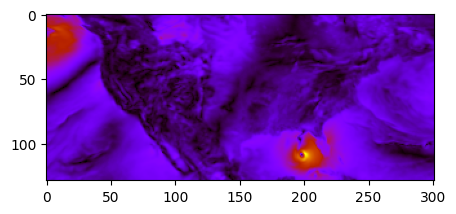

In [82]:
import matplotlib.pyplot as plt

time = datetime(2024, 9, 26) # initial condition 
lead_time1 = timedelta(hours = 15) # model run time, note that corrdiff only allows 24hr prediction
input_array = fetch_input_gefs(time, lead_time1)

#ensure the dimension of input is correct 
print(type(input_array), getattr(input_array, "shape", None), getattr(input_array, "dtype", None))

np.save("corrdiff_inputs.npy", input_array)

#check if the input is loaded correctly and valid 
input = np.load("corrdiff_inputs.npy")
wind_input = np.sqrt(input[0, 0, 0]**2 + input[0, 0, 1]**2)
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.imshow(wind_input, cmap="gnuplot")


Note that your input is extracted from GEFS data, which is a low resolution prediction from 25km. 

In [83]:
import io
import tarfile
from pathlib import Path
import numpy as np
import requests
import tqdm

url = f"http://corrdiff-nim-service-laurahu:8000/v1/infer"
files = {
    "input_array": ("input_array", open("corrdiff_inputs.npy", "rb")),
}
data = {
    "samples": 6, # users can choose how many samples they want to generate 
    "steps": 14, # users can also choose how many steps they want the diffusion mod to take 
    "seed": 0,
}
headers = {
    "accept": "application/x-tar",
}
print("Sending post request to NIM")
r = requests.post(url, headers=headers, data=data, files=files, timeout=3000)
if r.status_code != 200:
    raise Exception(r.content)
else:
    # Dump response to file
    with open("output.tar", "wb") as tar:
        tar.write(r.content)
print("Done!")

Sending post request to NIM
Done!


In [84]:
#check if the raw outputs make sense 

with tarfile.open("output.tar") as tar:
    for i, member in enumerate(tar.getmembers()):
        arr_file = io.BytesIO()
        arr_file.write(tar.extractfile(member).read())
        arr_file.seek(0)
        data = np.load(arr_file)

# A function that checks model outputs
def summarize(name, a):
    a = np.asarray(a)
    print(
        f"{name:8s}",
        "shape", a.shape,
        "finite", np.isfinite(a).all(),
        "min/max", float(np.nanmin(a)), float(np.nanmax(a)),
        "standard deviation", np.std(a),
        "p1/p50/p99", np.nanpercentile(a, [1,50,99]).tolist()
    )


var_names = ["u10m","v10m","t2m","tp","csnow","cicep","cfrzr","crain"]
var_input_name = ["u10m", "v10m","t2m", "r2m", "sp", "msl", "tcwv"]

B = 0

print("Input stats")
for vi, name in enumerate(var_input_name):
    x = input_array[B, :, vi, :, :]  # (S,H,W)
    summarize(name, x)
    print("----------")

print("Output stats")
for vi, name in enumerate(var_names):
    y = data[B, :, vi, :, :]  
    summarize(name, y)
    print("----------")

Input stats
u10m     shape (1, 129, 301) finite True min/max -28.144052505493164 27.925947189331055 standard deviation 3.7715628 p1/p50/p99 [-9.654052734375, -0.7540527582168579, 10.77314750671388]
----------
v10m     shape (1, 129, 301) finite True min/max -23.390644073486328 34.88935470581055 standard deviation 5.406924 p1/p50/p99 [-10.407844467163086, 0.059355467557907104, 17.53655616760255]
----------
t2m      shape (1, 129, 301) finite True min/max 269.1000061035156 305.6000061035156 standard deviation 6.0258436 p1/p50/p99 [275.8999938964844, 293.70001220703125, 303.20001220703125]
----------
r2m      shape (1, 129, 301) finite True min/max 10.233816146850586 99.9338150024414 standard deviation 20.046244 p1/p50/p99 [19.43381690979004, 73.5338134765625, 98.63381958007812]
----------
sp       shape (1, 129, 301) finite True min/max 68462.9375 102672.5390625 standard deviation 6568.383 p1/p50/p99 [76854.2328125, 99806.9375, 102371.288125]
----------
msl      shape (1, 129, 301) finit

We can see from the mismatch of each variable stats that the raw output from the model is normalized, we want to denormalize the output using the following function. To do so, we also want to extract the global mean and standard deviation of HRRR.

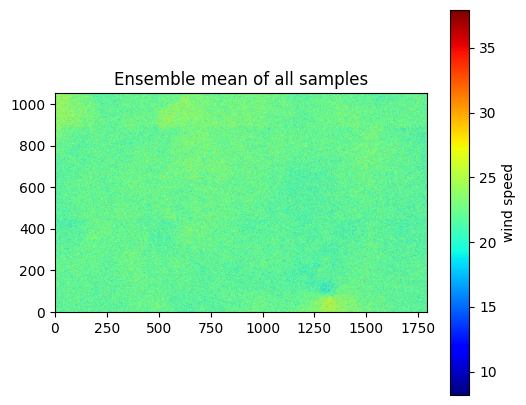

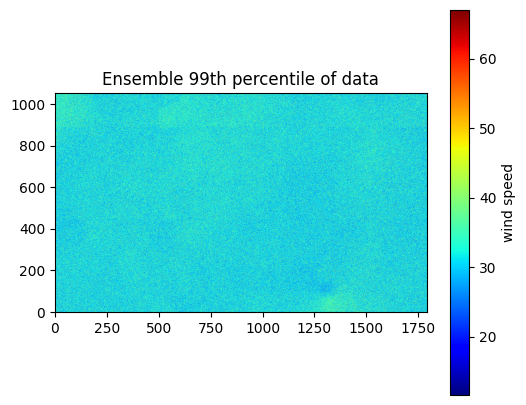

In [85]:
# make the ensemble visual 

def denormalize_output(normalized_output, means, stds):
    """
    Denormalize model output from HRRR normalized space to physical units
    Note: Channel 2 (t2m) is already in physical units, don't denormalize it!
    """
    denormalized = normalized_output.copy()
    
    # Denormalize each channel individually
    # Channel 0: u10m
    denormalized[0, 0, 0] = (normalized_output[0, 0, 0] * stds[0,0,0]) + means[0,0,0]
    
    # Channel 1: v10m
    denormalized[0, 0, 1] = (normalized_output[0, 0, 1] * stds[1,0,0]) + means[1,0,0]
    
    # Channel 2: t2m - ALREADY IN PHYSICAL UNITS, DON'T TOUCH
    # denormalized[0, 0, 2] = normalized_output[0, 0, 2]  # Already done by copy
    
    # Channels 3-7: precipitation variables (skip channel 3 in normalization file)
    # Use channels 4-8 from the normalization file
    for i in range(3, 8):
        denormalized[0, 0, i] = (normalized_output[0, 0, i] * stds[i+1,0,0]) + means[i+1,0,0]
    return denormalized

# global mean and standard deviation
output_means = np.load("corrdiff_us_hrrr_means.npy")
output_stds = np.load("corrdiff_us_hrrr_stds.npy")

sample = []
u = []
v = []

with tarfile.open("output.tar") as tar:
    for i, member in enumerate(tar.getmembers()):
        arr_file = io.BytesIO()
        arr_file.write(tar.extractfile(member).read())
        arr_file.seek(0)
        data = np.load(arr_file)

        data_denormalized = denormalize_output(data, output_means, output_stds)
        u10m = data_denormalized[0, 0, 0]
        v10m = data_denormalized[0, 0, 1]
        wind_10m_norm = np.sqrt(u10m**2 + v10m**2)

        sample.append(wind_10m_norm)
        u.append(u10m)
        v.append(v10m)
        
percentile = 100
sample = np.array(sample)
ensemble_mean = np.mean(sample, axis = 0)
ensemble_per = np.percentile(sample, percentile, axis = 0)
ensemble_u = np.mean(u, axis = 0)
ensemble_v = np.mean(v, axis = 0)

fig, ax = plt.subplots(1,1, figsize = (6,5))
ax.set_title("Ensemble mean of all samples")
im = ax.imshow(ensemble_mean, origin = "lower", cmap = "jet")
plt.colorbar(im, ax = ax, label = "wind speed")
plt.show()

fig, ax = plt.subplots(1,1, figsize = (6,5))
ax.set_title("Ensemble 99th percentile of data")
im = ax.imshow(ensemble_per, origin = "lower", cmap = "jet") # <--- this is the variable we will use 
plt.colorbar(im, ax = ax, label = "wind speed")
plt.show()


In [86]:

# The corrdinate system of corrdiff 
import numpy as np

# Load official NVIDIA coordinates
lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")

print(f"Latitudes: {lats.shape} - Range: {lats.min():.2f}° to {lats.max():.2f}°")
print(f"Longitudes: {lons.shape} - Range: {lons.min():.2f}° to {lons.max():.2f}°")
print(f"Resolution: ~{(lats.max()-lats.min())/len(lats):.4f}° lat × {(lons.max()-lons.min())/len(lons):.4f}° lon")

Latitudes: (1056, 1792) - Range: 21.19° to 52.56°
Longitudes: (1056, 1792) - Range: 226.08° to 298.94°
Resolution: ~0.0297° lat × 0.0690° lon


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter, zoom


# Load official coordinates
lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")
lons_west = lons - 360

# Set up Lambert Conformal projection
projection = ccrs.LambertConformal(
    central_longitude=np.median(lons_west),
    central_latitude=np.median(lats),
    standard_parallels=(33, 45)
)


fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=projection)
        
        # Plot smoothed data
c = ax.pcolormesh(
        lons_west, lats, 
        gaussian_filter(ensemble_per, sigma = 1), 
        transform=ccrs.PlateCarree(),
        cmap='turbo',
        )
        
        # Add geographic features
ax.coastlines(linewidth=2, color='black')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='darkgray')
ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')
ax.add_feature(cfeature.OCEAN, alpha=0.2, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Title with statistics
max_wind = ensemble_mean.max()
ax.set_title(
    f"Ensemble mean - Wind Speed Forecast (Max: {max_wind:.1f} m/s = {max_wind*2.237:.0f} mph)\n"
    f"Hurricane Helene - 3km Resolution - Lambert Conformal Projection",
    fontsize=16, fontweight='bold', pad=15
)

# Colorbar
cbar = plt.colorbar(c, ax=ax, shrink=0.7, pad=0.05)
cbar.set_label('Wind Speed (m/s)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


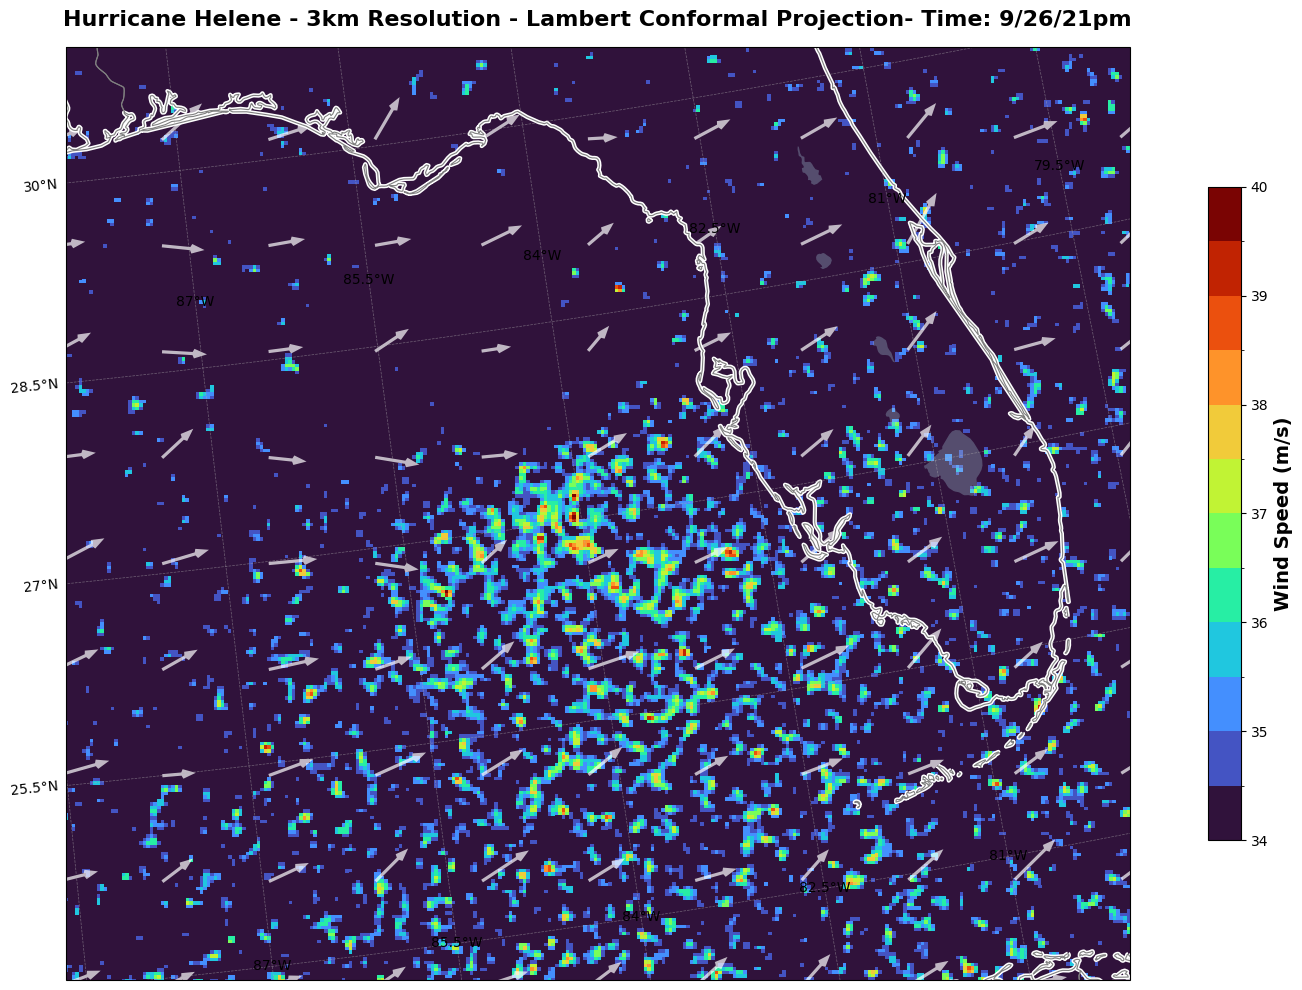

In [81]:
##### import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---------- load grids ----------
lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")
lons_west = lons - 360

# ---------- map projection ----------
projection = ccrs.LambertConformal(
    central_longitude=float(np.mean(lons_west)),
    central_latitude=float(np.mean(lats)),
    standard_parallels=(33, 45)
)
pc = ccrs.PlateCarree()

# Florida Big Bend extent
la_lon = [-88.0, -80.0]
la_lat = [24.0, 30.0]


# ---------- Get ensemble mean u and v components ----------
# downsample the data 
factor = 1/2
ensemble_wind_down = zoom(ensemble_per, factor, order = 1)
lats_new = zoom(lats, factor, order = 1)
lons_new = zoom(lons_west, factor, order = 1)


# ---------- Create plot ----------
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# Plot wind speed (color background)

levels = [34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40]
norm = mcolors.BoundaryNorm(levels, ncolors = 256)
c = ax.pcolormesh(
    lons_west, lats,
    gaussian_filter(ensemble_per, sigma = 1),
    transform=pc,
    norm = norm, 
    cmap='turbo'
)

# Set the view extent
ax.set_extent([la_lon[0], la_lon[1], la_lat[0], la_lat[1]], crs=pc)


# Add the quiver plot 
skip = 30  # Plot every 30th point (adjust for density)

quiver = ax.quiver(
    lons_west[::skip, ::skip], 
    lats[::skip, ::skip],
    ensemble_u[::skip, ::skip],
    ensemble_v[::skip, ::skip],
    transform=pc,
    color='white', # Arrow color  
    alpha = 0.7,
    scale = 500, # Arrow size (smaller = longer arrows)
    width=0.003,             # Arrow shaft width
    headwidth=3,             # Arrow head width
    headlength=4,            # Arrow head length
)

# Add quiver plot 
quiver

# Add geographic features
ax.coastlines(linewidth=3, color='white')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='darkgray')
ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')
ax.add_feature(cfeature.OCEAN, alpha=0.2, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


ax.set_title(
    f"Hurricane Helene - 3km Resolution - Lambert Conformal Projection"
    f"- Time: 9/26/15pm",
    fontsize=16, fontweight='bold', pad=15
)

# Colorbar
cbar = plt.colorbar(c, ax=ax, shrink=0.7, pad=0.05)
cbar.set_label('Wind Speed (m/s)', fontsize=14, fontweight='bold')
plt.savefig("HurrHele_sample_26_15.png", dpi = 300)
plt.tight_layout()
plt.show()
